# Tugas Akhir 
#### Author:  Marcelina

# Import Library

In [1]:
#Scrape data
import snscrape.modules.twitter as sntwitter 

#Save or load data
import pickle
import ast #convert txt file into dictionary

#Data pre-processing
import pandas as pd
import numpy as np
import itertools
import re # to manipulate string
from datetime import date, timedelta # convert datetime

from nltk.tokenize import word_tokenize 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

#Feature engineering modules and test_train_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

#Classification algorithm
from sklearn.svm import SVC

#Create classification report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report

#Topic Modeling
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import ldamodel

ModuleNotFoundError: No module named 'gensim'

In [ ]:
pd.set_option('display.max_colwidth', 0)

# Data Scraping

In [3]:
# create list of date
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

#create a two months date        
start_date = date(2021, 5, 2)
end_date = date(2021, 7, 1)

#scrape data from 1 May 20221
search = '"vaksin covid" OR "vaksin corona" OR "vaksin sinovac" OR "vaksin astrazeneca" OR "vaksin sinopharm"'
df = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    '{} since:2021-05-01 until:2021-05-02 lang:id exclude:retweets -filter:links'.format(search)).get_items(), 500))

#scrape data from 1 May 2021 - 30 June 2021
for single_date in daterange(start_date, end_date):
    df = df.append(pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    '{} since:"{}" until:"{}" lang:id exclude:retweets -filter:links'.format(search,single_date, single_date+pd.Timedelta(days=1))).get_items(), 500))
                               , ignore_index=True)


In [5]:
len(df)

12776

In [6]:
#create a date only column
df['date_only'] = df['date'].dt.date

# Changing object type column to datetime
df['date_only'] = pd.to_datetime(df.date_only)

print(df.groupby('date_only').count().content)


### Malaysians' Tweets Removal

In [4]:
df = df[['url', 'date', 'content', 'renderedContent', 'id', 'user', 'replyCount',
                     'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'lang',
                     'source', 'sourceUrl', 'sourceLabel', 'outlinks', 'tcooutlinks',
                     'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId',
                     'inReplyToUser', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
                     'cashtags', 'date_only']]

In [6]:
print('sample from content column :\n')
print(df.content.iloc[11], '\n')
print('sample from user column :\n')
print(df.user.iloc[11], '\n')
print('sample from place columns :\n')
print(df.place.iloc[11])

sample from content column :

Aku nak tanya soalan serius ni, siapa esok daftar nak ambik vaksin AstraZeneca? Kalau korang ambik aku ambik. 

sample from user column :

{'username': 'shahrilathif', 'id': 1046235311305441280, 'displayname': 'ShahrIlathif', 'description': 'Doing business @empiredamansara as airbnb operator. #EmpihausEmpireDamansara. Otak movie, kaki bola, suka buat playlist lagu', 'rawDescription': 'Doing business @empiredamansara as airbnb operator. #EmpihausEmpireDamansara. Otak movie, kaki bola, suka buat playlist lagu', 'descriptionUrls': None, 'verified': False, 'created': datetime.datetime(2018, 9, 30, 3, 8, 31, tzinfo=datetime.timezone.utc), 'followersCount': 134, 'friendsCount': 480, 'statusesCount': 14104, 'favouritesCount': 37865, 'listedCount': 0, 'mediaCount': 696, 'location': '', 'protected': False, 'linkUrl': None, 'linkTcourl': None, 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1421138298131521539/BZCDgKgl_normal.jpg', 'profileBannerUrl': 'http

In [7]:
#function to convert string into lowercase
def lowercase(df, cols):
    for col in cols:
        df[col] = df[col].str.lower()
    return df

#functions to get certain element in a cell
def find_location(txt):
    result = re.search("(?<='location': ').*?(?=',)", txt)
    if result:
        return result.group()
    else:
        return ''
    
def find_country(txt):
    if pd.isnull(txt):
        return ''
    result = re.search("(?<='country': ').*?(?=',)", txt)
    if result:
        return result.group()
    else:
        return ''
    
def find_username(txt):
    result = re.search("(?<='username': ').*?(?=',)", txt)
    if result:
        return result.group()
    else:
        return ''

cols = ['content', 'user', 'place', 'hashtags']
df = lowercase(df, cols)

df['location'] = df.user.apply(find_location)
df['country'] = df.place.apply(find_country)
df['username'] = df.user.apply(find_username)

In [8]:
#Import created list of places in Malaysia

# with open("my_loc.txt", "wb") as fp:   #Pickling
#     pickle.dump(my_loc, fp)
with open("material/my_loc.txt", "rb") as fp:   # Unpickling
    my_loc = pickle.load(fp)

In [9]:
# 1. remove tweet that created in malaysia area
df = df[~(df.location.str.contains(my_loc, na=False)) & ~(df.country == 'malaysia') ]

# 2. remove tweet that created by malaysian user

# step 1 find username of tweets that contains malaysian phrase
my_phrase = ['(?<= )(cucuk|amik|korang|rehat|melayu|pulak|je|nak|korang|inject|tengok|antivax|malaysia|sikit|taknak|takde|@jkjavmy|nak ambik|nak tanya|dose|sihat|ambik|nk|pasal|kj|tempahan|cuba|jadik|kerajaan|sahaja|mesej|register|seronok|amek|nurse|lenguh|setakat|teruk|dos|gov|boleh ke|temu|macam mana|macam ni|pasai|pharmaniaga|syarikat|ramai|volunteer|book|bawak|kot|faham|haritu|camne|protect|🇲🇾|abah|diorang|minit|cakap|makcik|kat|semak|tarikh|kongsi)(?= |\.|\!|\?)',
             '(?<=)(kerajaan|tempahan|tempah|@khairykj)(?= |\.|\!|\?)']
             
my_user = df[(~(df.location.str.contains('indonesia|jakarta|jawa|sumatra|sulawesi|bandung|banten|depok|bali|jkt|tangerang|palembang|surabaya|cgk|bsd|denpasar|jayapura', na=False))
        & ~(df.place.str.contains('indonesia', na=False))) 
         & df.content.str.findall(my_phrase[0])
        ].username.unique().tolist()
             
my_user = my_user + df[(~(df.location.str.contains('indonesia|jakarta|jawa|sumatra|sulawesi|bandung|banten|depok|bali|jkt|tangerang|palembang|surabaya|cgk|bsd|denpasar|jayapura', na=False))
                    & ~(df.place.str.contains('indonesia', na=False))) 
                     & df.content.str.findall(my_phrase[1])
                    ].username.unique().tolist()

# step 2 find username of tweets that contains malaysian location
my_user = my_user + (df[(~(df.location.str.contains('indonesia|jakarta|jawa|sumatra|sulawesi|bandung|banten|depok|bali|jkt|tangerang|palembang|surabaya|cgk|bsd|denpasar|jayapura', na=False))
                & ~(df.place.str.contains('indonesia', na=False))) 
                 & df.content.str.contains(my_loc)
                ].username.unique().tolist())

# step 3 remove duplicates username by creating dictionary, and convert to list
my_user = list(dict.fromkeys(my_user))

#step 4 remove tweets created by users in our list
df = df[~df.username.isin(my_user)]


In [10]:
len(my_user)

1543

In [11]:
len(df)

8689

In [12]:
#remove duplicates
df.drop_duplicates(subset="content",
                     keep = 'first', inplace = True)
df.reset_index(drop = True, inplace = True)

In [13]:
len(df)

8643

# Data Pre-processing

In [14]:
#data cleaning & casefolding
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\'," ")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")
    return text
    

# function to replace slang words
def slang_replace(sentence):
    #open file
    file = open("material/modified_slang_words.txt", "r")
    content = file.read()
    slang_dict = ast.literal_eval(content)
    file.close()
    
    sentence_replaced = ""
    for word in sentence.split():
        if word in slang_dict:
            sentence_replaced += slang_dict[word]
        else:
            sentence_replaced += word
        sentence_replaced += ' '
    sentence_replaced = sentence_replaced.strip()
    return sentence_replaced

#stopwords removal WITHOUT TOKENIZING
def stopwords_removal(text):
    #use sastrawi library
    factory_stopwords = StopWordRemoverFactory()
    stopwords_sastrawi = factory_stopwords.get_stop_words()
    not_stopwords = ['boleh','bukan', 'tidak']
    new_stopwords = [x for x in stopwords_sastrawi if x not in not_stopwords]

    sentence_replaced = ""
    for i in text.split():
        if i not in new_stopwords:
            sentence_replaced += i
            sentence_replaced += ' '
    sentence_replaced = sentence_replaced.strip()
    return sentence_replaced

#stemming WITHOUT TOKENIZING
def stem_words(text):
    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return ' '.join(stemmer.stem(i) for i in text.split())

#tokenization
def word_tokenize_wrapper(text):
    return word_tokenize(text)

def preprocess(df):
    #CLEANING------
    df['cleaned'] = df['content'].apply(remove_tweet_special)
    #Remove Number 
    df['cleaned']= df['cleaned'].str.replace('\d+','',regex=True)
    #Remove unwanted Characters(_,?????)
    df['cleaned'] = df['cleaned'].str.replace(r"[^a-zA-Z ]+", " ",regex=True).str.strip()
    # Remove multiple whitespace to single 
    df['cleaned'] = df['cleaned'].replace('/\s\s+/g'," ",regex=True)
    #Case folding : Convert to lowercase
    df["cleaned"]= df["cleaned"].str.lower()
    
    #NORMALIZATION----
    df['normalized'] = df['cleaned'].apply(slang_replace)
    
    #STOPWORDS REMOVAL----
    df['no_stopwords'] = df['normalized'].apply(stopwords_removal)
    
    #STEMMING
    df['stemmed'] = df['no_stopwords'].apply(stem_words)
    
    #TOKENIZATION
    df['tokenized'] = df['stemmed'].apply(word_tokenize_wrapper)

    return df

In [15]:
df = preprocess(df)

# Split Data with Ratio 80% and 20%

In [104]:
b_df = df.sample(frac =.2)
a_df = df.loc[~tweet_df.index.isin(sample_df.index)]

In [107]:
b_df.to_csv(r'C:\Users\ASUS\Jupyter Notebook Files\Tugas Akhir\data\tweetduabulan_sample071021.csv', index = False)
a_df.to_csv(r'C:\Users\ASUS\Jupyter Notebook Files\Tugas Akhir\data\tweetduabulan_rest071021.csv', index = False)

data will be labeled manually by author

# Lexicon Labeling

In [16]:
#import data which have been labeled by the author
a_df = pd.read_csv("data/tweetduabulan_rest_sentiment.csv")
b_df = pd.read_csv('data/tweetduabulan_sample_sentiment.csv')

a_df = a_df.fillna('')
b_df = b_df.fillna('')

there are many irrelevant tweets, such as quiz-giveaway tweets which contains "covid" in the tweets.

In [20]:
#check how many tweets is irrelevant

print(len(a_df[a_df.content.str.contains('@arusbaik_id',na=False)].content))
print(len(b_df[b_df.content.str.contains('@arusbaik_id',na=False)].content))

132
38


In [21]:
a_df = a_df[~a_df.content.str.contains('@arusbaik_id',na=False)]
b_df = b_df[~b_df.content.str.contains('@arusbaik_id',na=False)]

a_df = a_df.reset_index(drop = True)
b_df = b_df.reset_index(drop = True)

In [22]:
all_df = pd.concat([a_df, b_df], ignore_index=True)

In [23]:
a_df[['date_only','content']].loc[6767:6770]

,date_only,content
6767,6/30/2021,@lwilianty @kegblgnunfaedh saya vaksin sinovac. alhamdulillah msh hidup..🤗
6768,6/30/2021,"jadi gmn, penerima vaksin sinovac harus dapat dosis ketiga atau vaksin lagi dgn merek lain?\n\nmasalahnya, who tidak merekomendasikan keduanya ya?"
6769,6/30/2021,"@ery_rizaldy @arie_kriting vaksin2 tuh diteliti brp taun br produksi, nah ini vaksin covid br diteliti seumur jagung koq udah produksi besar2an.. klo suka jd kelinci percobaan y gpp jg siy, klo gwe siy ogah 😄"
6770,6/30/2021,@pandatemsek km vaksin sinovac atau az?


### Create the lexicon

In [24]:
# Create word dictionary based on 80% data
word_dict = {}
for i in range(0,len(all_df['no_stopwords'])):
    sentence = all_df['no_stopwords'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [25]:
print('number of unique words :',len(word_dict))
print('number of unique words with frequency >= 4 times :',len({k:v for (k,v) in word_dict.items() if v >= 4}))

number of unique words : 13438
number of unique words with frequency >= 4 times : 3068


In [26]:
# list of words that occured >50 times
{k:v for (k,v) in word_dict.items() if v > 50}

{'vaksin': 12313,
 'covid': 4632,
 'negara': 284,
 'dunia': 95,
 'bandung': 53,
 'rakyat': 94,
 'beli': 52,
 'bahan': 62,
 'lain-lain': 73,
 'tidak': 3202,
 'menerima': 175,
 'biar': 125,
 'tuh': 162,
 'sinovac': 3353,
 'bilang': 120,
 'flu': 99,
 'bukan': 337,
 'imun': 65,
 'tubuh': 170,
 'takut': 257,
 'iya': 1322,
 'salah': 121,
 'efektif': 87,
 'varian': 124,
 'min': 150,
 'usia': 270,
 'umum': 85,
 'corona': 344,
 'coba': 91,
 'oh': 57,
 'virus': 237,
 'badan': 330,
 'masyarakat': 179,
 'nakes': 66,
 'resiko': 56,
 'selamat': 111,
 'sore': 59,
 'pfizer': 161,
 'who': 213,
 'maaf': 70,
 'astrazeneca': 2265,
 'efek': 1035,
 'sampingnya': 107,
 'lapar': 265,
 'bpom': 63,
 'antibodi': 54,
 'prokes': 63,
 'gratis': 152,
 'juta': 199,
 'dosis': 509,
 'mei': 89,
 'jakarta': 146,
 'sm': 81,
 'beda': 134,
 'si': 120,
 'kemarin': 410,
 'eh': 108,
 'samping': 238,
 'pasca': 77,
 'suntik': 294,
 'dr': 228,
 'pemerintah': 278,
 'tidur': 173,
 'disuntik': 232,
 'tangan': 166,
 'kiri': 66,
 'sak

In [150]:
#CREATE LEXICON

import csv

# Read in the lexicon. 
#Load InSet sentiment word
neg = pd.read_csv('material/InSet-master/negative.tsv', sep='\t', header=0)
pos = pd.read_csv('material/InSet-master/positive.tsv', sep='\t', header=0)
lexicon_df1 = pd.concat((neg,pos), axis = 0)
lexicon_df1 = lexicon_df1.groupby('word').sum().reset_index()
lexicon_df1 = lexicon_df1[lexicon_df1.weight != 0]

#agusmakmun lexicon
txt_file = r"material/SentiStrengthID-master/id_dict/sentimentword.txt"
csv_file = r"material/SentiStrengthID-master/id_dict/sentimentword.csv"

# convert txt file to csv file
with open(txt_file, 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(" ") for line in stripped if line)
    with open(csv_file, 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('word', 'weight'))
        writer.writerows(lines)
        
lexicon_df2 = pd.read_csv(csv_file)
lexicon_df3 = pd.read_csv('material/additional_lexicon.csv')

#combine lexicon 1 and lexicon 2
lexicon_df = lexicon_df1.merge(lexicon_df2, indicator='i', how='outer')
#.query('i == "left_only"').drop('i', 1)
lexicon_df['duplicate'] = lexicon_df.duplicated(subset='word', keep=False)
lexicon_df = lexicon_df[(lexicon_df.i != 'right_only') | (lexicon_df.duplicate != True)]

#combine combined lexicon and lexicon 3
lexicon_df = lexicon_df.merge(lexicon_df3, indicator='ii', how='outer')
lexicon_df['duplicate'] = lexicon_df.duplicated(subset='word', keep=False)
lexicon_df = lexicon_df[(lexicon_df.ii != 'right_only') | (lexicon_df.duplicate != True)]

#count its occurences in corpus
lexicon_df['count'] = lexicon_df['word'].apply(lambda x : word_dict[x] if x in word_dict else 0)

lexicon_df.reset_index(drop=True, inplace = True)


In [151]:
lexicon_df.sort_values(by='count', ascending = False).head(40)

,word,weight,i,duplicate,ii,count
8472,tidak,-5,left_only,False,left_only,3202
2156,efek,3,left_only,False,left_only,1035
8954,demam,-2,right_only,False,left_only,494
9725,pegal,-4,NaN,False,right_only,444
2924,informasi,-1,left_only,False,left_only,428
5995,ngantuk,-2,left_only,False,left_only,350
7267,sakit,-5,left_only,False,left_only,341
1486,bukan,-3,left_only,False,left_only,337
1413,boleh,2,left_only,False,left_only,335
393,badan,-3,left_only,False,left_only,330


In [152]:
#there are many words that has sentiment value that is not fit the context. So we would modify it
lexicon_df[lexicon_df.word == 'tidak'] = lexicon_df.assign(weight = -3)
lexicon_df[lexicon_df.word == 'dok'] = lexicon_df.assign(weight = 0)
lexicon_df[lexicon_df.word == 'positif'] = lexicon_df.assign(weight = -3)
lexicon_df[lexicon_df.word == 'negatif'] = lexicon_df.assign(weight = 3)
lexicon_df[lexicon_df.word == 'bagus'] = lexicon_df.assign(weight = 3)
lexicon_df[lexicon_df.word == 'informasi'] = lexicon_df.assign(weight = 0)
lexicon_df[lexicon_df.word == 'anak'] = lexicon_df.assign(weight = 0)
lexicon_df[lexicon_df.word == 'takut'] = lexicon_df.assign(weight = -5)

lexicon_df_modified = lexicon_df.copy()
lexicon_df_modified = lexicon_df_modified[['word', 'weight']]

Check whether there is significant word that is not in our lexicon

In [153]:
#find word that is not in our lexicon
lexicon_word = lexicon_df_modified['word'].tolist()
ns_words = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)

# get list of words that occured more than 3 times and not in our lexicon
ns_words_list = {k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3))}
print('There are {} words that is occured more than 3 times but not in our lexicon\n'.format(len(ns_words_list)))

#Check whether there is insignificant word that need to be added in our lexicon
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse=True)
sort_orders=sort_orders[0:300]
for i in sort_orders:
    print(i[0], i[1])

There are 1670 words that is occured more than 3 times but not in our lexicon

vaksin 12313
covid 4632
sinovac 3353
astrazeneca 2265
iya 1322
habis 700
dosis 509
indonesia 485
sih 481
vaksinasi 415
kemarin 410
pakai 407
sinopharm 363
corona 344
jam 329
divaksin 307
kakak 304
tahun 301
suntik 294
negara 284
usia 270
amp 266
virus 237
disuntik 232
dr 228
makan 218
who 213
suntikan 184
masyarakat 179
emang 174
program 172
tuh 162
pfizer 161
cina 159
dimana 153
waktu 151
minggu 151
min 150
jakarta 146
dokter 145
besok 138
juni 136
vaksinnya 133
deh 131
kantor 130
tahap 125
siang 124
kepala 123
bilang 120
si 120
saudi 116
ktp 113
haji 112
eh 108
warga 108
puskesmas 100
gotong 97
uang 96
royong 95
rakyat 94
yaa 94
arab 92
doang 91
ngomong-ngomong 90
mei 89
lengan 85
daerah 84
mas 84
jadwal 82
sm 81
rs 81
batch 79
pasca 77
syarat 74
lokasi 73
paracetamol 71
dg 69
area 69
nakes 66
imun 65
kondisi 65
nafsu 65
bpom 63
prokes 63
total 63
imunisasi 61
so 61
surat 60
update 60
sore 59
kah 58
oh 57


Turns out there's no significant word that need to be added to our lexicon.

In [ ]:
# Save our lexicon
lexicon_df_modified.to_csv('material/modified_lexicon.csv',index=False)

## Sentiment labeling with lexicon

In [27]:
lexicon_df_modified = pd.read_csv('material/modified_lexicon.csv')

In [28]:
negation = ['tidak', 'bukan']
lexicon_dict = dict(lexicon_df_modified.values)

def calculate_sentiment3(sentence):
    score = 0 
    words = sentence.split()
    for i in range(len(words)):
        if words[i] in lexicon_dict:
            #check whether the words have negative score AND have negation word in previous index
            if ((lexicon_dict[words[i]]<0) & (words[i-1] in negation)): 
                #delete the previous negation score and add absolute value of negative word
                score = score + abs(lexicon_dict[words[i-1]]) + abs(lexicon_dict[words[i]]) #invertion
            else:
                score = score + lexicon_dict[words[i]]
    return score

a_df['score'] = a_df['no_stopwords'].apply(calculate_sentiment3)
a_df ['lexicon_sentiment'] = a_df['score'].apply(lambda x: 'positive' if x>1 else ('negative' if x<-1 else 'neutral'))
b_df['score'] = b_df['no_stopwords'].apply(calculate_sentiment3)
b_df['lexicon_sentiment'] = b_df['score'].apply(lambda x: 'positive' if x>1 else ('negative' if x<-1 else 'neutral'))

In [29]:
print('Akurasi pelabelan leksikon terhadap pelabelan manual pada data a = {:.2f}%'.format(len(a_df[a_df.real_sentiment == a_df.lexicon_sentiment])/len(a_df)))
print('Akurasi pelabelan leksikon terhadap pelabelan manual pada data b = {:.2f}% '.format(len(b_df[b_df.real_sentiment == b_df.lexicon_sentiment])/len(b_df)))

Akurasi pelabelan leksikon terhadap pelabelan manual pada data a = 0.47%
Akurasi pelabelan leksikon terhadap pelabelan manual pada data b = 0.54% 


In [30]:
print('Data A')
print(a_df[['content', 'real_sentiment']].groupby(['real_sentiment']).count())
print(a_df[['content', 'lexicon_sentiment']].groupby(['lexicon_sentiment']).count())
print('---------------------\nData B')
print(b_df[['content', 'real_sentiment']].groupby(['real_sentiment']).count())
print(b_df[['content', 'lexicon_sentiment']].groupby(['lexicon_sentiment']).count())

Data A
                content
real_sentiment         
negative        2010   
neutral         3788   
positive        984    
                   content
lexicon_sentiment         
negative           3172   
neutral            1699   
positive           1911   
---------------------
Data B
                content
real_sentiment         
negative        664    
neutral         559    
positive        468    
                   content
lexicon_sentiment         
negative           845    
neutral            394    
positive           452    


In [31]:
a_df[['date_only','content','cleaned', 'normalized',
       'no_stopwords', 'stemmed','real_sentiment','lexicon_sentiment']].loc[6767:6770]

,date_only,content,cleaned,normalized,no_stopwords,stemmed,real_sentiment,lexicon_sentiment
6767,6/30/2021,@lwilianty @kegblgnunfaedh saya vaksin sinovac. alhamdulillah msh hidup..🤗,saya vaksin sinovac alhamdulillah msh hidup,saya vaksin sinovac alhamdulillah masih hidup,vaksin sinovac alhamdulillah hidup,vaksin sinovac alhamdulillah hidup,positive,positive
6768,6/30/2021,"jadi gmn, penerima vaksin sinovac harus dapat dosis ketiga atau vaksin lagi dgn merek lain?\n\nmasalahnya, who tidak merekomendasikan keduanya ya?",jadi gmn penerima vaksin sinovac harus dapat dosis ketiga atau vaksin lagi dgn merek lain masalahnya who tidak merekomendasikan keduanya ya,jadi bagaimana penerima vaksin sinovac harus dapat dosis ketiga atau vaksin lagi dengan merek lain masalahnya who tidak merekomendasikan keduanya iya,penerima vaksin sinovac dosis ketiga vaksin merek who tidak merekomendasikan iya,terima vaksin sinovac dosis tiga vaksin merek who tidak rekomendasi iya,neutral,neutral
6769,6/30/2021,"@ery_rizaldy @arie_kriting vaksin2 tuh diteliti brp taun br produksi, nah ini vaksin covid br diteliti seumur jagung koq udah produksi besar2an.. klo suka jd kelinci percobaan y gpp jg siy, klo gwe siy ogah 😄",vaksin tuh diteliti brp taun br produksi nah ini vaksin covid br diteliti seumur jagung koq udah produksi besaran klo suka jd kelinci percobaan y gpp jg siy klo gwe siy ogah,vaksin tuh diteliti berapa tahun baru produksi nah ini vaksin covid baru diteliti seumur jagung kok sudah produksi besaran kalau suka jadi kelinci percobaan ya tidak apa-apa juga siy kalau gwe siy tidak mau,vaksin tuh diteliti tahun produksi vaksin covid diteliti seumur jagung produksi besaran suka kelinci percobaan tidak apa-apa siy gwe siy tidak,vaksin tuh teliti tahun produksi vaksin covid teliti umur jagung produksi besar suka kelinci coba tidak apa siy gwe siy tidak,negative,negative
6770,6/30/2021,@pandatemsek km vaksin sinovac atau az?,km vaksin sinovac atau az,kamu vaksin sinovac atau astrazeneca,vaksin sinovac astrazeneca,vaksin sinovac astrazeneca,neutral,neutral


# Sentiment Analysis

### Grid Search - Hyperparameter Tuning

In [68]:
x_train, x_test, y_train, y_test = train_test_split(a_df['stemmed'],a_df['real_sentiment'],
                                                    test_size = 0.30, stratify=a_df['real_sentiment'])
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(decision_function_shape='ovo'))
                    ])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel':['linear', 'poly', 'rbf']
    }
   

In [141]:
clf = GridSearchCV(text_clf , tuned_parameters, cv=5, n_jobs = -1, scoring = 'f1_macro')
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))
print(accuracy_score(y_test, clf.predict(x_test)))
print(confusion_matrix(y_test, clf.predict(x_test)))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)


              precision    recall  f1-score   support

    negative     0.5545    0.6501    0.5985       603
     neutral     0.7400    0.6983    0.7186      1137
    positive     0.5961    0.5153    0.5527       295

    accuracy                         0.6575      2035
   macro avg     0.6302    0.6212    0.6233      2035
weighted avg     0.6641    0.6575    0.6589      2035

0.6574938574938575
[[392 183  28]
 [268 794  75]
 [ 47  96 152]]
Best Score:  0.6077170847116662
Best Params:  {'clf__C': 1000, 'clf__kernel': 'linear', 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__ngram_range': (1, 3)}


### Build SVM Model

In [28]:
#Build Model

#1. trained on lexicon 80% (data A)
X = a_df['stemmed']
y = a_df['lexicon_sentiment']

# Create  classifier object.
lexicon_clf = Pipeline([('vect', CountVectorizer(ngram_range =(1,3), max_df = 1.0,max_features = None)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(C = 1000, kernel= 'linear', decision_function_shape='ovo'))])

lexicon_clf.fit(X, y)

#2. trained on manual 80% (data A)
X = a_df['stemmed']
y = a_df['real_sentiment']

# Create  classifier object.
manual_clf = Pipeline([('vect', CountVectorizer(ngram_range =(1,3), max_df = 1.0,max_features = None)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(C = 1000, kernel= 'linear', decision_function_shape='ovo'))])

manual_clf.fit(X, y)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SVC(C=1000, decision_function_shape='ovo', kernel='linear'))])

In [70]:
#3. trained on manual 20% (data B)
X = b_df['stemmed']
y = b_df['real_sentiment']

# Create  classifier object.
manual_test_clf = Pipeline([('vect', CountVectorizer(ngram_range =(1,3), max_df = 1.0,max_features = None)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC(C = 1000, kernel= 'linear', decision_function_shape='ovo'))])

manual_test_clf.fit(X, y)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SVC(C=1000, decision_function_shape='ovo', kernel='linear'))])

In [34]:
manual_clf.predict(['habis vaksin covid sedikit demam tapi alhadulilah sudah sembuh'])

array(['neutral'], dtype=object)

In [35]:
lexicon_clf.predict(['habis vaksin covid sedikit demam tapi alhadulilah sudah sembuh'])

array(['neutral'], dtype=object)

In [71]:
manual_test_clf.predict(['habis vaksin covid sedikit demam tapi alhadulilah sudah sembuh'])

array(['negative'], dtype=object)

In [ ]:
import pickle
# save the model to disk
filename = 'model/model_lexicon2_181121.sav'
pickle.dump(lexicon_clf, open(filename, 'wb'))

filename = 'model/model_manual2_181121.sav'
pickle.dump(manual_clf, open(filename, 'wb'))

filename = 'model/model_manual_test3_261121.sav'
pickle.dump(manual_test_clf, open(filename, 'wb'))

# Prediction

In [44]:
#Create prediction columns

# Training 80% lexicon, testing manual 20%
b_df['lexicon_sentiment_pred'] = lexicon_clf.predict(b_df['stemmed'])

# Training 20% manual, testing lexicon 80%
a_df['real_sentiment_pred'] = manual_test_clf.predict(a_df['stemmed'])

# Training 80% manual, testing lexicon 20%
# Training 80% manual, testing manual 20%
b_df['real_sentiment_pred'] = manual_clf.predict(b_df['stemmed'])

In [55]:
#model 1, Training 80% lexicon, testing 20% manual
# import pickle
filename = 'model/model_lexicon2_181121.sav'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

result = loaded_model.predict(b_df['stemmed'])
b_df['lexicon_sentiment_pred'] = result

col = 'lexicon_sentiment_pred'
print(b_df[['content', col]].groupby([col]).count())
print(classification_report(b_df['real_sentiment'], b_df[col], digits=4))
print('F1 score = {:.4f}'.format(f1_score(b_df['real_sentiment'], b_df[col], average='macro')))
print('confusion matrix\n',confusion_matrix(b_df['real_sentiment'], b_df[col]))

                        content
lexicon_sentiment_pred         
negative                922    
neutral                 294    
positive                475    
              precision    recall  f1-score   support

    negative     0.5466    0.7590    0.6356       664
     neutral     0.6054    0.3184    0.4174       559
    positive     0.4274    0.4338    0.4305       468

    accuracy                         0.5234      1691
   macro avg     0.5265    0.5037    0.4945      1691
weighted avg     0.5331    0.5234    0.5067      1691

F1 score = 0.4945
confusion matrix
 [[504  64  96]
 [205 178 176]
 [213  52 203]]


In [57]:
#Model 2
# training 20% manual testing 80% lexicon

import pickle
filename = 'model/model_manual_test3_261121.sav'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

result = loaded_model.predict(a_df['stemmed'])
a_df['real_sentiment_pred'] = result

col = 'real_sentiment_pred'
print(a_df[['content', col]].groupby([col]).count())

print(classification_report(a_df['lexicon_sentiment'], a_df[col], digits=4))
print('F1 score = {:.4f}'.format(f1_score(a_df['lexicon_sentiment'], a_df[col], average='macro')))
print('confusion matrix\n', confusion_matrix(a_df['lexicon_sentiment'], a_df[col]))


                     content
real_sentiment_pred         
negative             2419   
neutral              2820   
positive             1543   
              precision    recall  f1-score   support

    negative     0.6618    0.5047    0.5727      3172
     neutral     0.3645    0.6051    0.4550      1699
    positive     0.4530    0.3658    0.4047      1911

    accuracy                         0.4907      6782
   macro avg     0.4931    0.4919    0.4775      6782
weighted avg     0.5285    0.4907    0.4959      6782

F1 score = 0.4775
confusion matrix
 [[1601 1005  566]
 [ 393 1028  278]
 [ 425  787  699]]


In [60]:
#Model 3 
#training 80% manual, testing 20% lexicon
import pickle
filename = 'model/model_manual2_181121.sav'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

result = loaded_model.predict(b_df['stemmed'])
b_df['real_sentiment_pred'] = result

col = 'real_sentiment_pred'
print(b_df[['content', col]].groupby([col]).count())

print(classification_report(b_df['lexicon_sentiment'], b_df[col], digits=4))
print('F1 score = {:.4f}'.format(f1_score(b_df['lexicon_sentiment'], b_df[col], average ='macro')))
print('confusion matrix\n', confusion_matrix(b_df['lexicon_sentiment'], b_df[col]))

                     content
real_sentiment_pred         
negative             601    
neutral              870    
positive             220    
              precision    recall  f1-score   support

    negative     0.7255    0.5160    0.6030       845
     neutral     0.3103    0.6853    0.4272       394
    positive     0.5818    0.2832    0.3810       452

    accuracy                         0.4932      1691
   macro avg     0.5392    0.4948    0.4704      1691
weighted avg     0.5903    0.4932    0.5027      1691

F1 score = 0.4704
confusion matrix
 [[436 355  54]
 [ 86 270  38]
 [ 79 245 128]]


In [61]:
#model 4
#training 80% manual, testing 20% manual 

col = 'real_sentiment_pred'
print(b_df[['content', col]].groupby([col]).count())

print(classification_report(b_df['real_sentiment'], b_df[col], digits=4))
print('F1 score = {:.4f}'.format(f1_score(b_df['real_sentiment'], b_df[col], average ='macro')))
print('confusion matrix\n', confusion_matrix(b_df['real_sentiment'], b_df[col]))

                     content
real_sentiment_pred         
negative             601    
neutral              870    
positive             220    
              precision    recall  f1-score   support

    negative     0.7088    0.6416    0.6735       664
     neutral     0.5023    0.7818    0.6116       559
    positive     0.7136    0.3355    0.4564       468

    accuracy                         0.6032      1691
   macro avg     0.6416    0.5863    0.5805      1691
weighted avg     0.6419    0.6032    0.5930      1691

F1 score = 0.5805
confusion matrix
 [[426 213  25]
 [ 84 437  38]
 [ 91 220 157]]


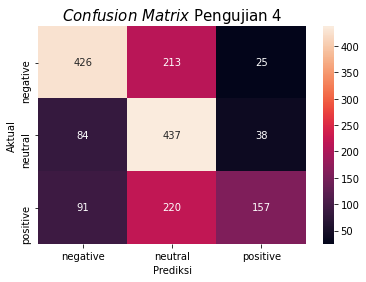

In [70]:
#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Current vs Prediction
confusion_matrix_val = pd.crosstab(b_df.real_sentiment, b_df.real_sentiment_pred, rownames= ['Aktual'], colnames=['Prediksi'])
ax = plt.axes() 
sns.heatmap(confusion_matrix_val, annot=True, fmt='g')
ax.set_title('$Confusion$ $Matrix$ Pengujian 4', size = 15)
plt.show()

In [147]:
# no need
tweet_df.to_csv('data/completedata_rest271121.csv',index=False)
test_df.to_csv('data/completedata_sample271121.csv',index=False)

### Predict all data with the best model (model 4)

In [73]:
filename = 'model/model_manual2_181121.sav'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

result = loaded_model.predict(all_df['stemmed'])
all_df['prediction'] = result

col = 'prediction'
print(all_df[['content', col]].groupby([col]).count())

print(classification_report(all_df['real_sentiment'], all_df[col], digits=4))
print('confusion matrix\n',confusion_matrix(all_df['real_sentiment'], all_df[col]))

            content
prediction         
negative    2609   
neutral     4665   
positive    1199   
              precision    recall  f1-score   support

    negative     0.9329    0.9102    0.9214      2674
     neutral     0.9046    0.9708    0.9365      4347
    positive     0.9433    0.7789    0.8533      1452

    accuracy                         0.9188      8473
   macro avg     0.9269    0.8867    0.9037      8473
weighted avg     0.9202    0.9188    0.9175      8473

confusion matrix
 [[2434  215   25]
 [  84 4220   43]
 [  91  230 1131]]


# Sentiment Analysis on May - June 2021 tweets

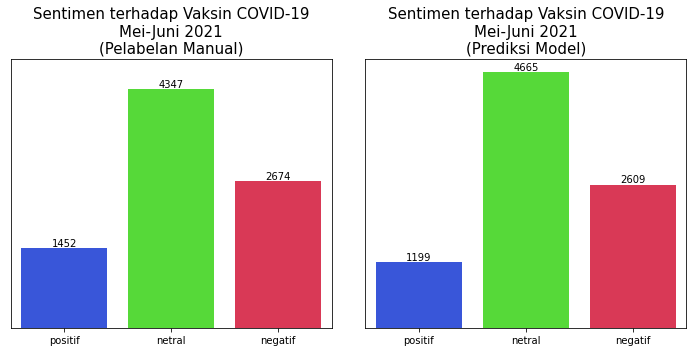

In [74]:
fig, ax = plt.subplots(1,2,figsize = (10,5), sharey = True)
cols = ['real_sentiment','prediction']
names = ['Pelabelan Manual', 'Prediksi Model']
for i in range(0, len(cols)):
    ax[i] = sns.countplot(x=cols[i], data = all_df, order = ['positive', 'neutral', 'negative'], 
                          palette=['#1F45F3',"#45F31F", '#F31F45'], 
                          ax=ax[i])
    ax[i].set_title('Sentimen terhadap Vaksin COVID-19\nMei-Juni 2021\n({})'.format(names[i]), size = 15)
#     Sentimen terhadap Vaksin COVID-19\nMei-Juni 2021\n({})
    ax[i].set_yticks([])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(['positif', 'netral', 'negatif'])
    rects = ax[i].patches
    # Make some labels.
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[i].text(
            rect.get_x() + rect.get_width() / 2, height + 5, rect.get_height(), ha="center", va="bottom"
        )
fig.tight_layout()
plt.show()

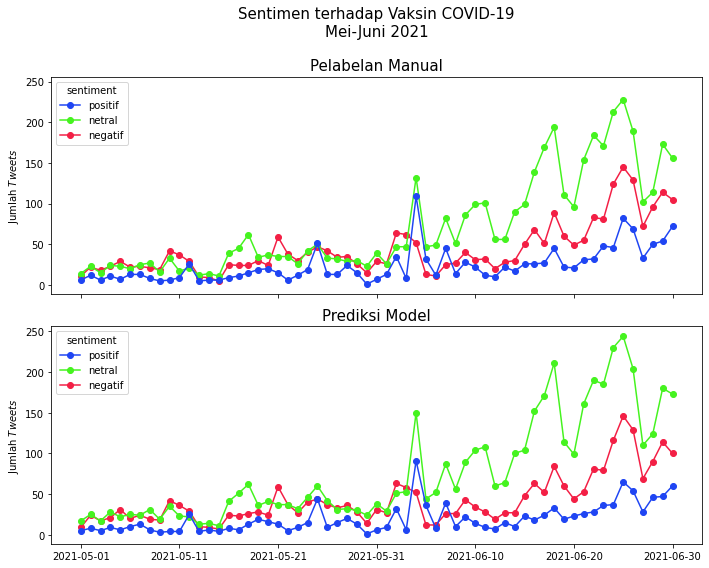

In [100]:
all_df.date_only = pd.to_datetime(all_df.date_only)
all_df = all_df.sort_values(by='date_only')
all_df['date_only'] = all_df['date_only'].dt.strftime('%Y-%m-%d')

fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
cols = ['real_sentiment','prediction']
names = ['Pelabelan Manual', 'Prediksi Model']
color_dict = {'positive':'#1F45F3', 'neutral': "#45F31F", 'negative':'#F31F45'}

for i in range(0,len(cols)):
    ax[i] = all_df.groupby(['date_only', cols[i]]).agg({'content': 'count'}).reset_index().pivot('date_only',
                                                                                                   cols[i], 
                                                                                                   'content').plot(kind='line', 
                                                                                                                   marker='o',  
                                                                                                                   color = color_dict, 
                                                                                                                   figsize=(10,8), ax=ax[i])
#     ax[i].set_title('Sentimen terhadap Vaksin COVID-19\nMei-Juni 2021\n({})'.format(names[i]), size = 15)
#     ax[i].set_xticks( [18763, 18794,18808])
#     ax[i].set_xticklabels(['\n\nMei', '\n\nJuni', ''])
    handles,labels = ax[i].get_legend_handles_labels()
    handles = [handles[2], handles[1], handles[0]]
    labels = ['positif', 'netral', 'negatif']
    ax[i].legend(handles, labels, title = 'sentiment')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Jumlah $Tweets$')
    
ax[0].set_title('Sentimen terhadap Vaksin COVID-19\nMei-Juni 2021\n\n{}'.format(names[0]), size = 15)
ax[1].set_title('{}'.format(names[1]), size = 15)

fig.tight_layout()
plt.savefig('senti_daily_compare3.png')
plt.show()

In [82]:
# Additional delete keyword
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

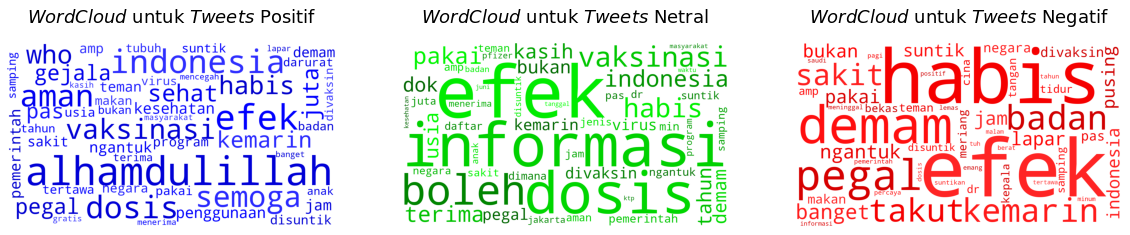

In [83]:
keyword = ['vaksin','covid','corona','sinovac','astrazeneca','sinopharm','iya', 'tidak', 'sih', 'kakak']

all_df = all_df.fillna('')
all_df['extra_cleaned']= all_df['no_stopwords'].apply(lambda x: del_word(x,keyword))


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import random 

# Generating words
col = 'extra_cleaned'
pos_comments = list(all_df.query('real_sentiment == "positive"')[col].values)
positive_words = ' '.join(pos_comments).split(' ')
neg_comments = list(all_df.query('real_sentiment == "negative"')[col].values)
negative_words = ' '.join(neg_comments).split(' ')
neu_comments = list(all_df.query('real_sentiment == "neutral"')[col].values)
neutral_words = ' '.join(neu_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)
neutral_dict = Counter(neutral_words)

def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(240, 100%%, %d%%)" % random.randint(40, 60)

def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(40, 60)

def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(120, 100%%, %d%%)" % random.randint(20, 50)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, mask = None ,
                      color_func= blue_color_func, background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, mask=None,
                      color_func= red_color_func, background_color='white', max_words=50).generate_from_frequencies(negative_dict)
neutral_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, mask=None,
                      color_func=green_color_func, background_color='white', max_words=50).generate_from_frequencies(neutral_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

sent_wc = [positive_wc, neutral_wc, negative_wc ]
sent_names = ['Positif', 'Netral','Negatif']
for i in range(0, len(sent_wc)):
    axs[i].imshow(sent_wc[i])
    axs[i].axis('off')
    axs[i].set_title('$WordCloud$ untuk $Tweets$ {}'.format(sent_names[i]), size=18, pad=20)


plt.show()

# Additional 

predict the testing data used on 4th model, which is 20% manually labeled data.

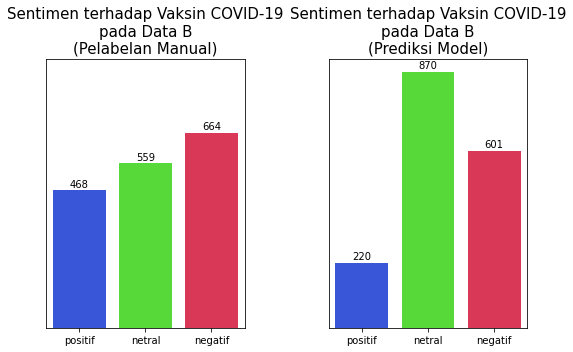

In [80]:
#bar chart

fig, ax = plt.subplots(1,2, figsize = (8,5), sharey = True)
cols = ['real_sentiment','real_sentiment_pred']
names = ['Pelabelan Manual', 'Prediksi Model']
for i in range(0, len(cols)):
    ax[i] = sns.countplot(x=cols[i], data = b_df, order = ['positive', 'neutral', 'negative'], 
                          palette=['#1F45F3',"#45F31F", '#F31F45'], 
                          ax=ax[i])
    ax[i].set_title('Sentimen terhadap Vaksin COVID-19\npada Data B\n({})'.format(names[i]), size = 15)
#     Sentimen terhadap Vaksin COVID-19\nMei-Juni 2021\n({})
    ax[i].set_yticks([])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(['positif', 'netral', 'negatif'])
    rects = ax[i].patches
    # Make some labels.
    labels = [f"label{i}" for i in range(len(rects))]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax[i].text(
            rect.get_x() + rect.get_width() / 2, height + 5, rect.get_height(), ha="center", va="bottom"
        )
        
# ax[0].set_title('Sentimen terhadap Vaksin COVID-19\npada Data B\n\n{}'.format(names[0]), size = 15)
# ax[1].set_title('{}'.format(names[1]), size = 15)

fig.tight_layout()
plt.show()

In [98]:
b_df.date_only = pd.to_datetime(b_df.date_only)
b_df = b_df.sort_values(by='date_only')
b_df['date_only'] = b_df['date_only'].dt.strftime('%Y-%m-%d')

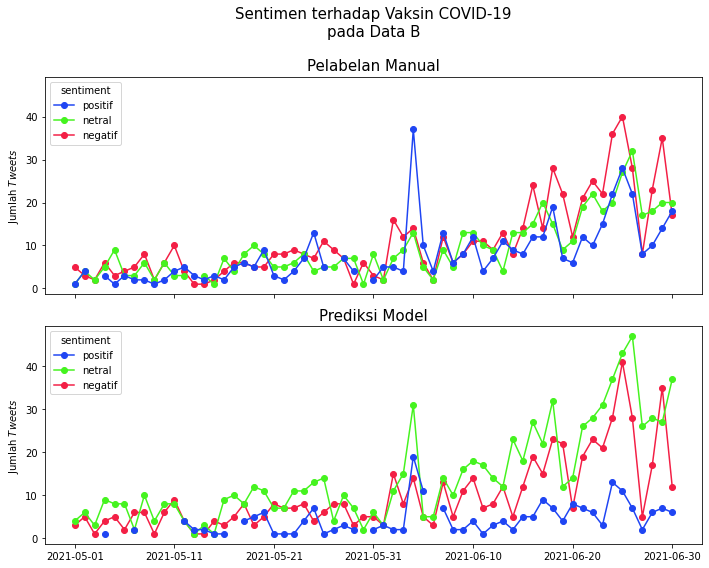

In [99]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
cols = ['real_sentiment','real_sentiment_pred']
names = ['Pelabelan Manual', 'Prediksi Model']
color_dict = {'positive':'#1F45F3', 'neutral': "#45F31F", 'negative':'#F31F45'}

for i in range(0,len(cols)):
    ax[i] = b_df.groupby(['date_only', cols[i]]).agg({'content': 'count'}).reset_index().pivot('date_only',
                                                                                                   cols[i], 
                                                                                                   'content').plot(kind='line', 
                                                                                                                   marker='o',  
                                                                                                                   color = color_dict, 
                                                                                                                   figsize=(10,8), ax=ax[i])

    handles,labels = ax[i].get_legend_handles_labels()
    handles = [handles[2], handles[1], handles[0]]
    labels = ['positif', 'netral', 'negatif']
    ax[i].legend(handles, labels, title = 'sentiment')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Jumlah $Tweets$')
    
ax[0].set_title('Sentimen terhadap Vaksin COVID-19\npada Data B\n\n{}'.format(names[0]), size = 15)
ax[1].set_title('{}'.format(names[1]), size = 15)

fig.tight_layout()
plt.savefig('senti_daily_compare_sample.png')
plt.show()

# Topic Modelling with Bags of Words

In [84]:
all_df.iloc[[6767,6768]][['content','stemmed','tokenized']]

,content,stemmed,tokenized
6767,@lwilianty @kegblgnunfaedh saya vaksin sinovac. alhamdulillah msh hidup..🤗,vaksin sinovac alhamdulillah hidup,"['vaksin', 'sinovac', 'alhamdulillah', 'hidup']"
6768,"jadi gmn, penerima vaksin sinovac harus dapat dosis ketiga atau vaksin lagi dgn merek lain?\n\nmasalahnya, who tidak merekomendasikan keduanya ya?",terima vaksin sinovac dosis tiga vaksin merek who tidak rekomendasi iya,"['terima', 'vaksin', 'sinovac', 'dosis', 'tiga', 'vaksin', 'merek', 'who', 'tidak', 'rekomendasi', 'iya']"


In [89]:
all_df['tokenized'] = all_df['stemmed'].apply(word_tokenize_wrapper)

In [90]:
# First, we are creating a dictionary from the data, 
# then convert to bag-of-words corpus 
dictionary = corpora.Dictionary(all_df['tokenized'])
corpus = [dictionary.doc2bow(text) for text in all_df['tokenized']]
id_words = [[(dictionary[id], count) for id, count in line] for line in corpus]
print(id_words)


[[('bandung', 1), ('covid', 1), ('dunia', 1), ('hidup', 1), ('kerennnn', 1), ('negara', 1), ('persib', 1), ('sah', 1), ('vaksin', 1)], [('covid', 1), ('vaksin', 1), ('bahan', 1), ('beli', 2), ('blt', 1), ('catat', 1), ('hibah', 1), ('inget', 1), ('jokowi', 1), ('kawan', 1), ('lain', 1), ('laki', 1), ('malaikat', 1), ('nambahin', 1), ('pokok', 1), ('rakyat', 1), ('saudara', 1), ('sembilan', 1), ('situ', 1), ('suudzon', 1), ('thr', 1), ('tidak', 1)], [('vaksin', 2), ('barang', 1), ('biar', 1), ('bilang', 1), ('bumn', 1), ('gadai', 1), ('komisaris', 1), ('ma', 1), ('nurut', 1), ('puji', 1), ('sampah', 1), ('sinovac', 2), ('suruh', 1), ('terima', 1), ('tuh', 1), ('wow', 1)], [('covid', 2), ('vaksin', 3), ('tidak', 2), ('benteng', 1), ('bukan', 1), ('digembargemborin', 1), ('flu', 1), ('gejala', 1), ('health', 1), ('imun', 1), ('iya', 3), ('mmg', 1), ('muncul', 1), ('otg', 1), ('persepsi', 1), ('salah', 1), ('stay', 1), ('takut', 1), ('tubuh', 1)], [('covid', 2), ('vaksin', 1), ('tidak', 1)

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=all_df['tokenized'], start=5, limit=21, step=1)

In [69]:
coherence_values

[0.43310906855193787,
 0.4141181765577208,
 0.41050289848832106,
 0.35626664582996315,
 0.42734673917111327,
 0.42393374360237573,
 0.4440338710710968,
 0.4253106542019936,
 0.43460215704667515,
 0.3675660923271541,
 0.4313741739455749,
 0.4006897649830569,
 0.44027086148859323,
 0.40179926832593754,
 0.4430736442051981,
 0.4066666010567997]

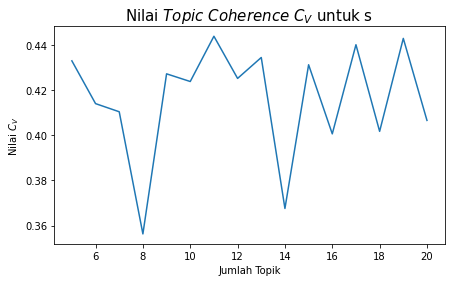

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show graph
limit=21; start=5; step=1;
x = range(start, limit, step)
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, coherence_values)
ax.set_xlabel("Jumlah Topik")
ax.set_ylabel("Nilai $C_V$ ")
ax.set_title('Nilai $Topic$ $Coherence$ $C_V$', size = 15)
plt.show()

In [139]:
#asking LDA to find 10 topics in the data:

topics = model_list[6].print_topics(num_words=15)
for topic in topics:
    print('')
    print(topic)


(0, '0.056*"mudah" + 0.018*"depok" + 0.016*"lancar" + 0.015*"ujung" + 0.012*"kategori" + 0.010*"ih" + 0.009*"sasar" + 0.009*"diagnosis" + 0.008*"johnson" + 0.007*"jasa" + 0.007*"nyuntik" + 0.007*"abal" + 0.006*"dada" + 0.006*"barang" + 0.005*"paksin"')

(1, '0.070*"vaksin" + 0.067*"sinovac" + 0.027*"who" + 0.021*"juni" + 0.021*"guna" + 0.018*"sinopharm" + 0.015*"saudi" + 0.015*"indonesia" + 0.014*"tanggal" + 0.013*"arab" + 0.013*"darurat" + 0.013*"efikasi" + 0.012*"astrazeneca" + 0.012*"tuju" + 0.012*"negara"')

(2, '0.016*"temu" + 0.016*"bayi" + 0.015*"kontra" + 0.013*"vaksin" + 0.013*"desa" + 0.012*"covid" + 0.010*"halal" + 0.010*"cacar" + 0.009*"beli" + 0.009*"adil" + 0.009*"tanda" + 0.009*"kutu" + 0.009*"jual" + 0.009*"abang" + 0.009*"judul"')

(3, '0.039*"emg" + 0.034*"alam" + 0.033*"cek" + 0.019*"normal" + 0.017*"telah" + 0.016*"tensi" + 0.013*"booster" + 0.013*"kmren" + 0.012*"us" + 0.009*"iyaa" + 0.009*"beres" + 0.009*"penasaran" + 0.008*"darah" + 0.007*"smpe" + 0.007*"lebih"'

In [141]:
#save our corpus and model for future use
import pickle
pickle.dump(corpus, open('model/corpus2_vaksintweet.pkl', 'wb'))
dictionary.save('model/dictionary2_vaksintweet.gensim')
filename = 'model/lda2_11topic.sav'
pickle.dump(model_list[6], open(filename, 'wb'))

# Additional

check tweets related with the topic produced by our model

In [10]:
all_df = all_df.fillna('')

In [13]:
#tokenization
def word_tokenize_wrapper(text):
    return word_tokenize(text)

all_df['tokenized'] = all_df['stemmed'].apply(word_tokenize_wrapper)

In [19]:
import pickle
# load the model from disk

# corpus = pickle.load(open('model/corpus2_vaksintweet.pkl', 'rb'))
dictionary = corpora.Dictionary(all_df['tokenized'])
corpus = [dictionary.doc2bow(text) for text in all_df['tokenized']]
id_words = [[(dictionary[id], count) for id, count in line] for line in corpus]

In [20]:
new_model = ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
new_coherencemodel = CoherenceModel(model=new_model, texts=all_df['tokenized'], dictionary=dictionary, coherence='c_v')

In [21]:
print(new_coherencemodel.get_coherence())
topics = new_model.print_topics(num_words=15)
for topic in topics:
    print('')
    print(topic)

0.4365365760774574

(0, '0.125*"vaksin" + 0.060*"covid" + 0.035*"tidak" + 0.030*"sinovac" + 0.017*"iya" + 0.010*"astrazeneca" + 0.009*"informasi" + 0.007*"anak" + 0.007*"terima" + 0.007*"tahun" + 0.006*"kasih" + 0.006*"boleh" + 0.006*"usia" + 0.006*"pakai" + 0.006*"bukan"')

(1, '0.081*"vaksin" + 0.035*"covid" + 0.018*"sinovac" + 0.016*"astrazeneca" + 0.014*"dosis" + 0.013*"indonesia" + 0.011*"vaksinasi" + 0.007*"juta" + 0.006*"aman" + 0.006*"guna" + 0.006*"terima" + 0.006*"varian" + 0.005*"perintah" + 0.005*"negara" + 0.005*"sinopharm"')

(2, '0.106*"vaksin" + 0.045*"sinovac" + 0.036*"tidak" + 0.029*"astrazeneca" + 0.027*"efek" + 0.019*"habis" + 0.013*"demam" + 0.012*"iya" + 0.011*"pegal" + 0.010*"suntik" + 0.010*"jam" + 0.010*"ngantuk" + 0.010*"sakit" + 0.010*"covid" + 0.009*"kemarin"')


In [97]:
print(new_coherencemodel.get_coherence())

0.39790691152576185


In [93]:
topics = new_model.print_topics(num_words=15)
for topic in topics:
    print('')
    print(topic)


(0, '0.118*"vaksin" + 0.049*"covid" + 0.030*"tidak" + 0.030*"sinovac" + 0.016*"astrazeneca" + 0.009*"indonesia" + 0.008*"iya" + 0.008*"dosis" + 0.007*"vaksinasi" + 0.006*"boleh" + 0.006*"perintah" + 0.006*"sinopharm" + 0.006*"tahun" + 0.006*"negara" + 0.005*"bukan"')

(1, '0.108*"vaksin" + 0.043*"sinovac" + 0.039*"tidak" + 0.032*"astrazeneca" + 0.026*"efek" + 0.019*"habis" + 0.014*"iya" + 0.014*"demam" + 0.012*"covid" + 0.012*"suntik" + 0.011*"pegal" + 0.009*"sih" + 0.009*"kemarin" + 0.009*"samping" + 0.009*"jam"')

(2, '0.093*"vaksin" + 0.059*"covid" + 0.017*"informasi" + 0.013*"iya" + 0.012*"terima" + 0.011*"sinovac" + 0.011*"kasih" + 0.008*"daftar" + 0.007*"mana" + 0.006*"tidak" + 0.006*"vaksinasi" + 0.006*"gratis" + 0.005*"min" + 0.005*"jakarta" + 0.005*"kakak"')


In [6]:
topics = [(0, '0.118*"vaksin" + 0.049*"covid" + 0.030*"tidak" + 0.030*"sinovac" + 0.016*"astrazeneca" + 0.009*"indonesia" + 0.008*"iya" + 0.008*"dosis" + 0.007*"vaksinasi" + 0.006*"boleh" + 0.006*"perintah" + 0.006*"sinopharm" + 0.006*"tahun" + 0.006*"negara" + 0.005*"bukan"'),
(1, '0.108*"vaksin" + 0.043*"sinovac" + 0.039*"tidak" + 0.032*"astrazeneca" + 0.026*"efek" + 0.019*"habis" + 0.014*"iya" + 0.014*"demam" + 0.012*"covid" + 0.012*"suntik" + 0.011*"pegal" + 0.009*"sih" + 0.009*"kemarin" + 0.009*"samping" + 0.009*"jam"'),
(2, '0.093*"vaksin" + 0.059*"covid" + 0.017*"informasi" + 0.013*"iya" + 0.012*"terima" + 0.011*"sinovac" + 0.011*"kasih" + 0.008*"daftar" + 0.007*"mana" + 0.006*"tidak" + 0.006*"vaksinasi" + 0.006*"gratis" + 0.005*"min" + 0.005*"jakarta" + 0.005*"kakak"')]

In [7]:
import re
newData =[ (tup[0],re.sub("[^A-Za-z|\"]","", tup[1])) for tup in topics]
# newData = [ (tup[0],re.sub("[\"]","\", "",tup[1])) for tup in newData]
newData

[(0,
  '"vaksin""covid""tidak""sinovac""astrazeneca""indonesia""iya""dosis""vaksinasi""boleh""perintah""sinopharm""tahun""negara""bukan"'),
 (1,
  '"vaksin""sinovac""tidak""astrazeneca""efek""habis""iya""demam""covid""suntik""pegal""sih""kemarin""samping""jam"'),
 (2,
  '"vaksin""covid""informasi""iya""terima""sinovac""kasih""daftar""mana""tidak""vaksinasi""gratis""min""jakarta""kakak"')]

# Download all data

In [102]:
all_df.to_csv('completedata_fix.csv', index=False)
a_df.to_csv('completedata_rest.csv', index=False)
b_df.to_csv('completedata_sample.csv', index=False)